# Imports

In [2]:
import time
import torch.nn as nn
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import pytorch_ssim  # For SSIM calculation
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import numpy as np

from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.functional import structural_similarity_index_measure as compute_ssim

c:\Users\zeina\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preproccessing

##### DIV2K dataset is used

In [ ]:
# This is run only once
from PIL import Image
import os

def center_crop_images(dataset_path):
    # List all image files in the dataset
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Initialize variables to store the minimum width and height
    min_width = float('inf')
    min_height = float('inf')
    
    # Find the smallest image dimensions
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)
    
    # Center crop all images to the size of the smallest image
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            # Calculate the cropping box (center crop)
            left = (width - min_width) // 2
            top = (height - min_height) // 2
            right = left + min_width
            bottom = top + min_height
            
            # Crop and save the image
            cropped_img = img.crop((left, top, right, bottom))
            cropped_img.save(os.path.join(dataset_path, f"cropped_{image_file}"))

# Crops all images in the dataset and saving them, original images were deleted manually by me
dataset_path = "./DIV2K_train_HR_Cropped"
center_crop_images(dataset_path)

## Synthetic LR Image Creation

In [3]:
class SRDataset(Dataset):
    def __init__(self, root_dir, transform=None, scale=2):
        self.files = sorted(os.listdir(root_dir))
        self.root_dir = root_dir
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(path).convert('RGB')  # Change from 'L' to 'RGB' for color images

        hr = img
        lr = hr.resize((hr.width // self.scale, hr.height // self.scale), Image.BICUBIC)
        lr = lr.resize((hr.width, hr.height), Image.BICUBIC)

        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)

        return lr, hr

In [3]:
    # Transform to convert images to tensors
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = SRDataset("./DIV2K_train_HR_Cropped", transform=transform, scale=2)

    # Split sizes (e.g., 90% train, 10% val)
train_size = int(0.9 * len(full_dataset))  # 720
val_size = len(full_dataset) - train_size  # 80

    # Split the dataset randomly
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1)
    

torch.Size([3, 648, 1116])


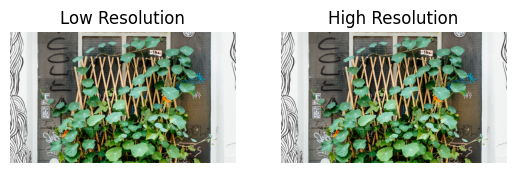

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[ 0.2039, -0.1373, -0.2902,  ...,  0.0353,  0.0549,  0.0196],
          [ 0.1647,  0.0549, -0.3294,  ..., -0.0588,  0.0392,  0.0314],
          [ 0.0745,  0.1255, -0.2471,  ..., -0.0588,  0.0431,  0.0549],
          ...,
          [-0.2706,  0.2078,  0.0902,  ...,  0.0039,  0.0078,  0.0000],
          [-0.2745,  0.1686,  0.1412,  ..., -0.0039,  0.0000,  0.0078],
          [-0.1882,  0.1608,  0.1569,  ...,  0.0000, -0.0078, -0.0118]],

         [[ 0.2078, -0.1412, -0.2902,  ...,  0.0353,  0.0549,  0.0275],
          [ 0.1686,  0.0588, -0.3255,  ..., -0.0588,  0.0314,  0.0275],
          [ 0.0784,  0.1216, -0.2510,  ..., -0.0588,  0.0392,  0.0510],
          ...,
          [-0.2784,  0.2078,  0.0902,  ...,  0.0039,  0.0078,  0.0000],
          [-0.2863,  0.1686,  0.1451,  ..., -0.0039,  0.0000,  0.0078],
          [-0.1922,  0.1686,  0.1569,  ...,  0.0000, -0.0078, -0.0118]],

         [[ 0.2039, -0.1373, -0.2902,  ...

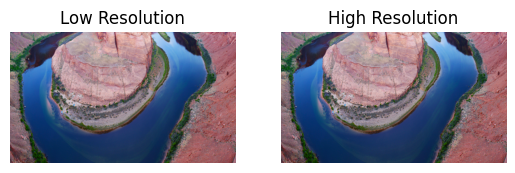

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[ 0.0157,  0.0118, -0.0510,  ..., -0.1216, -0.1059, -0.0863],
          [-0.0235,  0.0078,  0.0824,  ...,  0.0745,  0.0471, -0.0196],
          [ 0.0157, -0.0392, -0.0235,  ...,  0.0314,  0.0706,  0.0353],
          ...,
          [-0.0275,  0.0196,  0.0314,  ...,  0.0157, -0.0039, -0.0118],
          [-0.0196,  0.0157,  0.0314,  ...,  0.0078, -0.0118,  0.0000],
          [-0.0157,  0.0078,  0.0196,  ...,  0.0078, -0.0275, -0.0157]],

         [[ 0.0235,  0.0000, -0.0471,  ..., -0.0902, -0.0039,  0.0039],
          [-0.0353,  0.0196,  0.0353,  ...,  0.0039, -0.0157, -0.0314],
          [ 0.0039, -0.0118,  0.0039,  ...,  0.0235,  0.0353, -0.0314],
          ...,
          [ 0.0039, -0.0039,  0.0000,  ..., -0.0157, -0.0039,  0.0039],
          [ 0.0000, -0.0157,  0.0000,  ..., -0.0353, -0.0078,  0.0078],
          [-0.0039,  0.0039,  0.0353,  ..., -0.0235, -0.0118, -0.0039]],

         [[ 0.0353, -0.0157, -0.0353,  ...

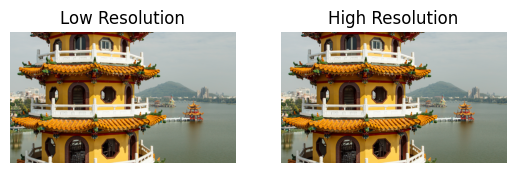

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0039,  0.0000,  0.0000,  ..., -0.0039,  0.0000, -0.0039],
          [ 0.0000, -0.0039,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0039, -0.0039,  ...,  0.0000,  0.0000, -0.0039],
          ...,
          [ 0.0078, -0.0157, -0.0078,  ...,  0.0000, -0.0039, -0.0078],
          [ 0.0039,  0.0000,  0.0039,  ...,  0.0078,  0.0196,  0.0078],
          [ 0.0000,  0.0039, -0.0078,  ...,  0.0000, -0.0078,  0.0000]],

         [[-0.0039,  0.0000,  0.0039,  ..., -0.0039,  0.0000, -0.0039],
          [ 0.0000, -0.0039,  0.0039,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0039,  0.0000, -0.0039,  ...,  0.0000,  0.0000, -0.0039],
          ...,
          [ 0.0118, -0.0118, -0.0078,  ..., -0.0039, -0.0078, -0.0118],
          [-0.0039, -0.0118,  0.0000,  ...,  0.0078,  0.0118,  0.0078],
          [ 0.0000,  0.0039, -0.0078,  ...,  0.0000, -0.0118,  0.0000]],

         [[-0.0039,  0.0000,  0.0000,  ...

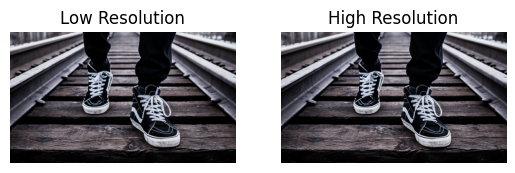

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0078,  0.0039, -0.0039,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0157,  0.0000,  0.0157,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0039,  0.0078,  0.0039,  ...,  0.0000,  0.0000, -0.0039],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0039,  0.0039]],

         [[-0.0078,  0.0039, -0.0039,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0157,  0.0000,  0.0157,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0039,  0.0078,  0.0039,  ...,  0.0000,  0.0000, -0.0039],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0039,  0.0039]],

         [[-0.0118,  0.0039,  0.0000,  ...

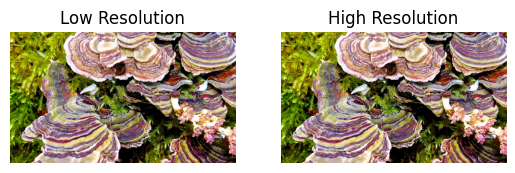

Difference shape: torch.Size([1, 3, 648, 1116])
Difference: tensor([[[[-0.0039,  0.0157, -0.0078,  ..., -0.0275, -0.0039,  0.0510],
          [-0.0314,  0.0118,  0.0039,  ..., -0.0118,  0.0000,  0.0235],
          [ 0.0078, -0.0078,  0.0118,  ..., -0.0118, -0.0431,  0.0196],
          ...,
          [ 0.0000, -0.0157, -0.0431,  ..., -0.0863, -0.1216,  0.0941],
          [-0.0039,  0.0157, -0.0039,  ...,  0.1922,  0.0196,  0.0235],
          [-0.0196,  0.0000,  0.0157,  ..., -0.0863, -0.0392,  0.0275]],

         [[ 0.0078,  0.0118, -0.0078,  ..., -0.0196, -0.0078,  0.0510],
          [-0.0353,  0.0078,  0.0078,  ..., -0.0039,  0.0000,  0.0235],
          [ 0.0157, -0.0078,  0.0157,  ..., -0.0157, -0.0510,  0.0157],
          ...,
          [-0.0039, -0.0157, -0.0392,  ..., -0.1020, -0.1451,  0.1059],
          [-0.0118,  0.0157, -0.0039,  ...,  0.2000, -0.0039,  0.0353],
          [-0.0196, -0.0118,  0.0118,  ..., -0.0745, -0.0667,  0.0471]],

         [[-0.0039,  0.0000,  0.0000,  ...

In [69]:
print(val_loader.dataset[0][0].shape)  # Check the shape of the first batch
# show images in val_loader
for i, (lr, hr) in enumerate(val_loader):
    if i == 5:
        break
    plt.subplot(1, 2, 1)
    plt.imshow(lr[0].permute(1, 2, 0).numpy())
    plt.title("Low Resolution")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(hr[0].permute(1, 2, 0).numpy())
    plt.title("High Resolution")
    plt.axis('off')
    plt.show()
    difference = hr - lr
    print("Difference shape:", difference.shape) # if the difference is not 0, then the images are different
    print("Difference:", difference)  # Check the difference between HR and LR images

##### The difference between the images are very subtle because the scale is x2 but the images are indeed different. As shown in the inference cell, cv2 shows the difference between LR and HR more accurately. 

# Model

In [4]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),  # 3 for RGB input
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)  # 3 for RGB output
        )

    def forward(self, x):
        return self.model(x)

# Evaluation Scoring Functions

In [71]:
import torch.nn as nn

class LossMSE(nn.Module):
    def __init__(self):
        super(LossMSE, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, output, target):
        return self.mse_loss(output, target)


In [ ]:
# another loss function I tried but didn't cause any improvement between lr and output images
# class SSIM_MSE_Loss(nn.Module):
#     def __init__(self, alpha=0.84, beta=0.16):
#         super(SSIM_MSE_Loss, self).__init__()
#         self.alpha = alpha
#         self.beta = beta
#         self.mse_loss = nn.MSELoss()

#     def forward(self, output, target):
#         ssim = structural_similarity_index_measure(output, target, data_range=1.0)
#         ssim_loss = 1 - ssim
#         mse_loss = self.mse_loss(output, target)
#         return self.alpha * ssim_loss + self.beta * mse_loss

In [10]:
def psnr(target, output, data_range=1.0):
    mse = np.mean((target - output) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(data_range / np.sqrt(mse))

# Evaluation Function

In [73]:
def evaluate(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for lr_img, hr_img in dataloader:
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            sr_img = model(lr_img).clamp(0.0, 1.0)
            
            psnr_val = psnr(hr_img.squeeze().cpu().numpy(), sr_img.squeeze().cpu().numpy())
            ssim_val = compute_ssim(sr_img, hr_img, data_range=1.0).item()
            
            psnr_scores.append(psnr_val)
            ssim_scores.append(ssim_val)

    return (
        sum(psnr_scores) / len(psnr_scores),
        sum(ssim_scores) / len(ssim_scores)
    )

## Plotting Graphs

In [74]:
def plot_learning_curve(epoch_losses, epoch_psnrs, epoch_ssims):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_psnrs) + 1), epoch_psnrs, label='Validation PSNR', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Validation PSNR Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    if epoch_ssims is not None:
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(epoch_ssims) + 1), epoch_ssims, label='Validation SSIM', color='purple')
        plt.xlabel('Epoch')
        plt.ylabel('SSIM')
        plt.title('Validation SSIM Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("ssim_curve.png")
        plt.show()

# Train Function

In [75]:
def train(model, train_dataloader, val_dataloader, epochs=5, lr=1e-4, log_dir="runs/SRCNNx2"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = LossMSE()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    writer = SummaryWriter(log_dir)

    epoch_losses = []
    epoch_psnrs = []
    epoch_ssims = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for lr_img, hr_img in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)

            output = model(lr_img)
            loss = criterion(output, hr_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        writer.add_scalar("Loss/Train", avg_loss, epoch)

        val_psnr, val_ssim = evaluate(model, val_dataloader)
        epoch_psnrs.append(val_psnr)
        epoch_ssims.append(val_ssim)
        writer.add_scalar("PSNR/Val", val_psnr, epoch)
        writer.add_scalar("SSIM/Val", val_ssim, epoch)


        model.eval()
        with torch.no_grad():
            for lr_img, hr_img in val_dataloader:
                lr_img = lr_img.to(device)
                output = model(lr_img).clamp(0.0, 1.0)
                writer.add_images("Input/LR", lr_img, epoch)
                writer.add_images("Output/SR", output, epoch)
                writer.add_images("Target/HR", hr_img.to(device), epoch)
                break  # Log only first batch

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

    writer.close()
    plot_learning_curve(epoch_losses, epoch_psnrs, epoch_ssims)
    return model

# Training The Model


Training SRCNN...


Epoch 1: 100%|██████████| 90/90 [00:36<00:00,  2.49it/s]
c:\Users\zeina\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1: Loss = 0.0535, PSNR = 19.11, SSIM = 0.5548


Epoch 2: 100%|██████████| 90/90 [00:35<00:00,  2.50it/s]


Epoch 2: Loss = 0.0094, PSNR = 22.55, SSIM = 0.6409


Epoch 3: 100%|██████████| 90/90 [01:00<00:00,  1.49it/s]


Epoch 3: Loss = 0.0058, PSNR = 23.92, SSIM = 0.6996


Epoch 4: 100%|██████████| 90/90 [00:45<00:00,  2.00it/s]


Epoch 4: Loss = 0.0045, PSNR = 25.04, SSIM = 0.7384


Epoch 5: 100%|██████████| 90/90 [00:36<00:00,  2.45it/s]


Epoch 5: Loss = 0.0037, PSNR = 25.88, SSIM = 0.7674


Epoch 6: 100%|██████████| 90/90 [00:37<00:00,  2.41it/s]


Epoch 6: Loss = 0.0033, PSNR = 26.36, SSIM = 0.7842


Epoch 7: 100%|██████████| 90/90 [00:38<00:00,  2.36it/s]


Epoch 7: Loss = 0.0030, PSNR = 26.68, SSIM = 0.7953


Epoch 8: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Epoch 8: Loss = 0.0028, PSNR = 26.99, SSIM = 0.8038


Epoch 9: 100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 9: Loss = 0.0027, PSNR = 27.25, SSIM = 0.8122


Epoch 10: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s]


Epoch 10: Loss = 0.0025, PSNR = 27.51, SSIM = 0.8221


Epoch 11: 100%|██████████| 90/90 [00:41<00:00,  2.17it/s]


Epoch 11: Loss = 0.0024, PSNR = 27.78, SSIM = 0.8293


Epoch 12: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 12: Loss = 0.0023, PSNR = 28.02, SSIM = 0.8371


Epoch 13: 100%|██████████| 90/90 [00:41<00:00,  2.17it/s]


Epoch 13: Loss = 0.0022, PSNR = 28.19, SSIM = 0.8424


Epoch 14: 100%|██████████| 90/90 [00:41<00:00,  2.15it/s]


Epoch 14: Loss = 0.0021, PSNR = 28.36, SSIM = 0.8464


Epoch 15: 100%|██████████| 90/90 [00:42<00:00,  2.13it/s]


Epoch 15: Loss = 0.0020, PSNR = 28.49, SSIM = 0.8496


Epoch 16: 100%|██████████| 90/90 [00:42<00:00,  2.12it/s]


Epoch 16: Loss = 0.0020, PSNR = 28.60, SSIM = 0.8523


Epoch 17: 100%|██████████| 90/90 [00:42<00:00,  2.10it/s]


Epoch 17: Loss = 0.0020, PSNR = 28.70, SSIM = 0.8549


Epoch 18: 100%|██████████| 90/90 [00:42<00:00,  2.10it/s]


Epoch 18: Loss = 0.0019, PSNR = 28.76, SSIM = 0.8570


Epoch 19: 100%|██████████| 90/90 [01:03<00:00,  1.42it/s]


Epoch 19: Loss = 0.0019, PSNR = 28.86, SSIM = 0.8587


Epoch 20: 100%|██████████| 90/90 [00:55<00:00,  1.62it/s]


Epoch 20: Loss = 0.0019, PSNR = 28.93, SSIM = 0.8604


Epoch 21: 100%|██████████| 90/90 [01:22<00:00,  1.09it/s]


Epoch 21: Loss = 0.0019, PSNR = 28.98, SSIM = 0.8622


Epoch 22: 100%|██████████| 90/90 [00:46<00:00,  1.95it/s]


Epoch 22: Loss = 0.0018, PSNR = 29.03, SSIM = 0.8636


Epoch 23: 100%|██████████| 90/90 [00:51<00:00,  1.75it/s]


Epoch 23: Loss = 0.0018, PSNR = 29.09, SSIM = 0.8648


Epoch 24: 100%|██████████| 90/90 [00:36<00:00,  2.49it/s]


Epoch 24: Loss = 0.0018, PSNR = 29.12, SSIM = 0.8660


Epoch 25: 100%|██████████| 90/90 [00:36<00:00,  2.48it/s]


Epoch 25: Loss = 0.0018, PSNR = 29.17, SSIM = 0.8670


Epoch 26: 100%|██████████| 90/90 [00:35<00:00,  2.51it/s]


Epoch 26: Loss = 0.0018, PSNR = 29.19, SSIM = 0.8679


Epoch 27: 100%|██████████| 90/90 [00:36<00:00,  2.50it/s]


Epoch 27: Loss = 0.0018, PSNR = 29.24, SSIM = 0.8688


Epoch 28: 100%|██████████| 90/90 [00:36<00:00,  2.48it/s]


Epoch 28: Loss = 0.0018, PSNR = 29.29, SSIM = 0.8697


Epoch 29: 100%|██████████| 90/90 [00:35<00:00,  2.51it/s]


Epoch 29: Loss = 0.0017, PSNR = 29.31, SSIM = 0.8705


Epoch 30: 100%|██████████| 90/90 [00:36<00:00,  2.48it/s]


Epoch 30: Loss = 0.0018, PSNR = 29.34, SSIM = 0.8715


Epoch 31: 100%|██████████| 90/90 [00:36<00:00,  2.46it/s]


Epoch 31: Loss = 0.0017, PSNR = 29.36, SSIM = 0.8719


Epoch 32: 100%|██████████| 90/90 [00:44<00:00,  2.04it/s]


Epoch 32: Loss = 0.0017, PSNR = 29.40, SSIM = 0.8727


Epoch 33: 100%|██████████| 90/90 [01:16<00:00,  1.17it/s]


Epoch 33: Loss = 0.0017, PSNR = 29.43, SSIM = 0.8734


Epoch 34: 100%|██████████| 90/90 [01:13<00:00,  1.22it/s]


Epoch 34: Loss = 0.0017, PSNR = 29.42, SSIM = 0.8739


Epoch 35: 100%|██████████| 90/90 [01:12<00:00,  1.24it/s]


Epoch 35: Loss = 0.0017, PSNR = 29.47, SSIM = 0.8746


Epoch 36: 100%|██████████| 90/90 [01:26<00:00,  1.04it/s]


Epoch 36: Loss = 0.0017, PSNR = 29.49, SSIM = 0.8753


Epoch 37: 100%|██████████| 90/90 [01:22<00:00,  1.09it/s]


Epoch 37: Loss = 0.0017, PSNR = 29.51, SSIM = 0.8757


Epoch 38: 100%|██████████| 90/90 [00:35<00:00,  2.54it/s]


Epoch 38: Loss = 0.0017, PSNR = 29.53, SSIM = 0.8762


Epoch 39: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]


Epoch 39: Loss = 0.0017, PSNR = 29.56, SSIM = 0.8768


Epoch 40: 100%|██████████| 90/90 [01:15<00:00,  1.19it/s]


Epoch 40: Loss = 0.0017, PSNR = 29.52, SSIM = 0.8773


Epoch 41: 100%|██████████| 90/90 [01:20<00:00,  1.12it/s]


Epoch 41: Loss = 0.0017, PSNR = 29.60, SSIM = 0.8777


Epoch 42: 100%|██████████| 90/90 [01:25<00:00,  1.06it/s]


Epoch 42: Loss = 0.0017, PSNR = 29.58, SSIM = 0.8778


Epoch 43: 100%|██████████| 90/90 [01:18<00:00,  1.14it/s]


Epoch 43: Loss = 0.0016, PSNR = 29.63, SSIM = 0.8785


Epoch 44: 100%|██████████| 90/90 [01:27<00:00,  1.03it/s]


Epoch 44: Loss = 0.0017, PSNR = 29.53, SSIM = 0.8789


Epoch 45: 100%|██████████| 90/90 [01:17<00:00,  1.16it/s]


Epoch 45: Loss = 0.0016, PSNR = 29.64, SSIM = 0.8788


Epoch 46: 100%|██████████| 90/90 [00:38<00:00,  2.33it/s]


Epoch 46: Loss = 0.0016, PSNR = 29.66, SSIM = 0.8795


Epoch 47: 100%|██████████| 90/90 [00:38<00:00,  2.31it/s]


Epoch 47: Loss = 0.0016, PSNR = 29.69, SSIM = 0.8799


Epoch 48: 100%|██████████| 90/90 [00:48<00:00,  1.84it/s]


Epoch 48: Loss = 0.0017, PSNR = 29.06, SSIM = 0.8785


Epoch 49: 100%|██████████| 90/90 [01:27<00:00,  1.03it/s]


Epoch 49: Loss = 0.0016, PSNR = 29.70, SSIM = 0.8803


Epoch 50: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s]


Epoch 50: Loss = 0.0016, PSNR = 29.72, SSIM = 0.8807


Epoch 51: 100%|██████████| 90/90 [01:10<00:00,  1.28it/s]


Epoch 51: Loss = 0.0016, PSNR = 29.72, SSIM = 0.8810


Epoch 52: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s]


Epoch 52: Loss = 0.0016, PSNR = 29.73, SSIM = 0.8812


Epoch 53: 100%|██████████| 90/90 [01:10<00:00,  1.28it/s]


Epoch 53: Loss = 0.0016, PSNR = 29.73, SSIM = 0.8813


Epoch 54: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s]


Epoch 54: Loss = 0.0016, PSNR = 29.46, SSIM = 0.8808


Epoch 55: 100%|██████████| 90/90 [01:02<00:00,  1.43it/s]


Epoch 55: Loss = 0.0016, PSNR = 29.77, SSIM = 0.8820


Epoch 56: 100%|██████████| 90/90 [00:59<00:00,  1.51it/s]


Epoch 56: Loss = 0.0016, PSNR = 29.79, SSIM = 0.8822


Epoch 57: 100%|██████████| 90/90 [00:38<00:00,  2.37it/s]


Epoch 57: Loss = 0.0016, PSNR = 29.79, SSIM = 0.8824


Epoch 58: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]


Epoch 58: Loss = 0.0016, PSNR = 29.80, SSIM = 0.8826


Epoch 59: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


Epoch 59: Loss = 0.0016, PSNR = 29.82, SSIM = 0.8829


Epoch 60: 100%|██████████| 90/90 [00:36<00:00,  2.44it/s]


Epoch 60: Loss = 0.0016, PSNR = 29.82, SSIM = 0.8830


Epoch 61: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s]


Epoch 61: Loss = 0.0016, PSNR = 29.83, SSIM = 0.8833


Epoch 62: 100%|██████████| 90/90 [01:09<00:00,  1.29it/s]


Epoch 62: Loss = 0.0016, PSNR = 29.84, SSIM = 0.8834


Epoch 63: 100%|██████████| 90/90 [00:36<00:00,  2.46it/s]


Epoch 63: Loss = 0.0016, PSNR = 29.84, SSIM = 0.8836


Epoch 64: 100%|██████████| 90/90 [00:36<00:00,  2.48it/s]


Epoch 64: Loss = 0.0016, PSNR = 29.79, SSIM = 0.8835


Epoch 65: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s]


Epoch 65: Loss = 0.0016, PSNR = 29.60, SSIM = 0.8830


Epoch 66: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s]


Epoch 66: Loss = 0.0016, PSNR = 29.86, SSIM = 0.8840


Epoch 67: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


Epoch 67: Loss = 0.0016, PSNR = 29.88, SSIM = 0.8842


Epoch 68: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


Epoch 68: Loss = 0.0016, PSNR = 29.88, SSIM = 0.8843


Epoch 69: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


Epoch 69: Loss = 0.0016, PSNR = 29.87, SSIM = 0.8844


Epoch 70: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


Epoch 70: Loss = 0.0016, PSNR = 29.68, SSIM = 0.8842


Epoch 71: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s]


Epoch 71: Loss = 0.0016, PSNR = 29.90, SSIM = 0.8848


Epoch 72: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


Epoch 72: Loss = 0.0016, PSNR = 29.91, SSIM = 0.8850


Epoch 73: 100%|██████████| 90/90 [00:35<00:00,  2.51it/s]


Epoch 73: Loss = 0.0016, PSNR = 29.91, SSIM = 0.8851


Epoch 74: 100%|██████████| 90/90 [00:41<00:00,  2.19it/s]


Epoch 74: Loss = 0.0016, PSNR = 29.92, SSIM = 0.8852


Epoch 75: 100%|██████████| 90/90 [00:36<00:00,  2.46it/s]


Epoch 75: Loss = 0.0016, PSNR = 29.92, SSIM = 0.8853


Epoch 76: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s]


Epoch 76: Loss = 0.0016, PSNR = 29.92, SSIM = 0.8853


Epoch 77: 100%|██████████| 90/90 [00:35<00:00,  2.51it/s]


Epoch 77: Loss = 0.0016, PSNR = 29.93, SSIM = 0.8856


Epoch 78: 100%|██████████| 90/90 [00:35<00:00,  2.51it/s]


Epoch 78: Loss = 0.0016, PSNR = 29.93, SSIM = 0.8856


Epoch 79: 100%|██████████| 90/90 [00:35<00:00,  2.50it/s]


Epoch 79: Loss = 0.0016, PSNR = 29.96, SSIM = 0.8859


Epoch 80: 100%|██████████| 90/90 [01:08<00:00,  1.32it/s]


Epoch 80: Loss = 0.0016, PSNR = 29.93, SSIM = 0.8857


Epoch 81: 100%|██████████| 90/90 [01:25<00:00,  1.05it/s]


Epoch 81: Loss = 0.0016, PSNR = 29.96, SSIM = 0.8861


Epoch 82: 100%|██████████| 90/90 [01:21<00:00,  1.11it/s]


Epoch 82: Loss = 0.0016, PSNR = 29.93, SSIM = 0.8862


Epoch 83: 100%|██████████| 90/90 [01:09<00:00,  1.29it/s]


Epoch 83: Loss = 0.0016, PSNR = 29.98, SSIM = 0.8862


Epoch 84: 100%|██████████| 90/90 [00:37<00:00,  2.39it/s]


Epoch 84: Loss = 0.0015, PSNR = 29.98, SSIM = 0.8864


Epoch 85: 100%|██████████| 90/90 [00:38<00:00,  2.35it/s]


Epoch 85: Loss = 0.0016, PSNR = 29.95, SSIM = 0.8862


Epoch 86: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Epoch 86: Loss = 0.0015, PSNR = 30.00, SSIM = 0.8865


Epoch 87: 100%|██████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 87: Loss = 0.0015, PSNR = 30.00, SSIM = 0.8866


Epoch 88: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 88: Loss = 0.0016, PSNR = 29.94, SSIM = 0.8865


Epoch 89: 100%|██████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 89: Loss = 0.0015, PSNR = 30.01, SSIM = 0.8869


Epoch 90: 100%|██████████| 90/90 [00:40<00:00,  2.25it/s]


Epoch 90: Loss = 0.0015, PSNR = 30.01, SSIM = 0.8870


Epoch 91: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 91: Loss = 0.0015, PSNR = 30.02, SSIM = 0.8871


Epoch 92: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 92: Loss = 0.0015, PSNR = 30.03, SSIM = 0.8871


Epoch 93: 100%|██████████| 90/90 [00:44<00:00,  2.00it/s]


Epoch 93: Loss = 0.0015, PSNR = 30.00, SSIM = 0.8871


Epoch 94: 100%|██████████| 90/90 [01:07<00:00,  1.33it/s]


Epoch 94: Loss = 0.0015, PSNR = 30.03, SSIM = 0.8874


Epoch 95: 100%|██████████| 90/90 [01:03<00:00,  1.42it/s]


Epoch 95: Loss = 0.0016, PSNR = 29.84, SSIM = 0.8867


Epoch 96: 100%|██████████| 90/90 [01:23<00:00,  1.08it/s]


Epoch 96: Loss = 0.0015, PSNR = 30.05, SSIM = 0.8877


Epoch 97: 100%|██████████| 90/90 [00:55<00:00,  1.63it/s]


Epoch 97: Loss = 0.0015, PSNR = 30.06, SSIM = 0.8876


Epoch 98: 100%|██████████| 90/90 [00:39<00:00,  2.26it/s]


Epoch 98: Loss = 0.0015, PSNR = 30.05, SSIM = 0.8876


Epoch 99: 100%|██████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 99: Loss = 0.0015, PSNR = 30.07, SSIM = 0.8879


Epoch 100: 100%|██████████| 90/90 [00:40<00:00,  2.21it/s]


Epoch 100: Loss = 0.0015, PSNR = 30.06, SSIM = 0.8880


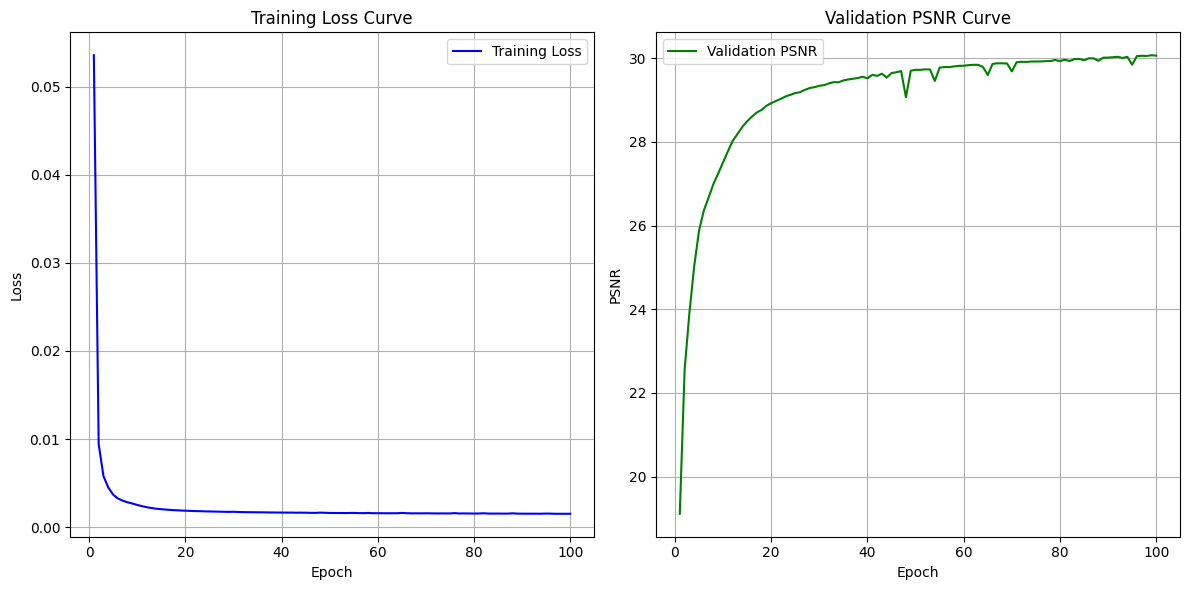

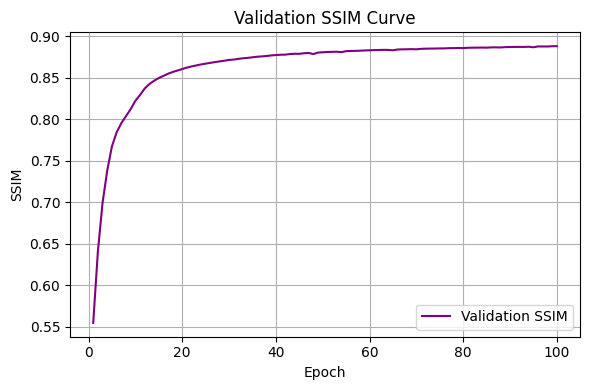

Time taken to train SRCNN: 93.35 minutes


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nTraining SRCNN...")
start_time = time.time()
srcnn = train(SRCNN(), train_loader, val_loader, epochs=100)
end_time = time.time()

    # print time taken to train in minutes 
print(f"Time taken to train SRCNN: {(end_time - start_time) / 60:.2f} minutes")

In [77]:
torch.save(srcnn.state_dict(), "srcnnx2.pth")

# Inference 

In [5]:
model = SRCNN()
model.load_state_dict(torch.load("srcnnx2.pth"))
model.eval()

SRCNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [13]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"SRCNNx2lr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"SRCNNx2sr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"SRCNNx2hr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 29.61 dB
SSIM: 0.9395
Example 2
PSNR: 30.76 dB
SSIM: 0.8677
Example 3
PSNR: 29.40 dB
SSIM: 0.9318
Example 4
PSNR: 31.78 dB
SSIM: 0.9360


### Comparision Images between Models

In [11]:
# This is run only once
from PIL import Image
import os

def center_crop_images(dataset_path):
    # List all image files in the dataset
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Initialize variables to store the minimum width and height
    min_width = float('inf')
    min_height = float('inf')
    
    # Find the smallest image dimensions
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)
    
    # Center crop all images to the size of the smallest image
    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            # Calculate the cropping box (center crop)
            left = (width - min_width) // 2
            top = (height - min_height) // 2
            right = left + min_width
            bottom = top + min_height
            
            # Crop and save the image
            cropped_img = img.crop((left, top, right, bottom))
            cropped_img.save(os.path.join(dataset_path, f"cropped_{image_file}"))

# Crops all images in the dataset and saving them, original images were deleted manually by me
dataset_path = "./comparison_images"
center_crop_images(dataset_path)

In [12]:
    # Transform to convert images to tensors
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = SRDataset("./comparison_images", transform=transform, scale=2)

    # Dataloaders
val_loader = DataLoader(full_dataset, batch_size=1)


In [13]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"SRCNNx2lr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"SRCNNx2sr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"SRCNNx2hr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 37.64 dB
SSIM: 0.9649
Example 2
PSNR: 38.09 dB
SSIM: 0.9725
Example 3
PSNR: 35.64 dB
SSIM: 0.8361
Example 4
PSNR: 38.25 dB
SSIM: 0.9497
